Background:

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”

Goal(s):

Predict how fit the candidate is based on their available information (variable fit)

Success Metric(s):

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

In [2]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 119.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=82a3099a6b8f290d5449154d9e493a9335bd8b3a0b1466325d4b83c25b5f31a1
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers


In [3]:
import pandas as pd
import numpy as np

import re

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

from src.features.build_features import Preprocess

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
project_dir = Path('__file__').resolve().parents[1]
file_path = project_dir.joinpath("data/raw/potential-talents - Aspiring human resources - seeking human resources.csv")
file_path

In [4]:
data = pd.read_csv(file_path)
data.head()

In [5]:
data.describe(include = object)

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


In [6]:
data.duplicated().sum()

0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [8]:
data.drop(['fit'],axis=1, inplace=True)

In [9]:
data.shape

(104, 4)

In [10]:
data['job_title'].value_counts()

2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
Aspiring Human Resources Professional                                                                                    7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
People Development Coordinator at Ryan                                                                                   6
Native English Teacher at EPIK (English Program in Korea)                                                                5
Aspiring Human Resources Specialist                                                                                      5
HR Senior Specialist                                                                                                     5
Student at Chapman University                                                                                            4
SVP, CHRO, Marke

In [11]:
data['location'].value_counts()

Kanada                                 12
Raleigh-Durham, North Carolina Area     8
Houston, Texas Area                     8
Greater New York City Area              7
Houston, Texas                          7
Denton, Texas                           6
San Francisco Bay Area                  5
Greater Philadelphia Area               5
İzmir, Türkiye                          4
Lake Forest, California                 4
Atlanta, Georgia                        4
Chicago, Illinois                       2
Austin, Texas Area                      2
Greater Atlanta Area                    2
Amerika Birleşik Devletleri             2
Long Beach, California                  1
Milpitas, California                    1
Greater Chicago Area                    1
Torrance, California                    1
Greater Los Angeles Area                1
Bridgewater, Massachusetts              1
Lafayette, Indiana                      1
Kokomo, Indiana Area                    1
Las Vegas, Nevada Area            

### Preprocess Text

In [13]:
cleaned_df = Preprocess()
cleaned_df.preprocess_texts(data)

,id,job_title,location,connection
0,1,ct bauer college of business graduate magna c...,"Houston, Texas",85
1,2,native english teacher at epik english program...,canada,500
2,3,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44
3,4,people development coordinator at ryan,"Denton, Texas",500
4,5,advisory board member at celal bayar university,"İzmir, Turkey",500
...,...,...,...,...
99,100,aspiring human resources manager graduating m...,"Cape Girardeau, Missouri",103
100,101,human resources generalist at loparex,"Raleigh-Durham, North Carolina Area",500
101,102,business intelligence and analytics at travelers,Greater New York City Area,49
102,103,always set them up for success,Greater Los Angeles Area,500


In [14]:
data['job_title'] = data['job_title'].apply(cleaned_df.text_lemmatization)
data['job_title'].unique()

array(['ct bauer college business graduate magna cum laude aspiring human resource professional',
       'native english teacher epik english program korea',
       'aspiring human resource professional',
       'people development coordinator ryan',
       'advisory board member celal bayar university',
       'aspiring human resource specialist',
       'student humber college aspiring human resource generalist',
       'human resource senior specialist',
       'seeking human resource human resourcesis generalist position',
       'student chapman university',
       'svp chuman resourceso marketing communication csr officer engie houston woodland energy gphuman resource sphuman resource',
       'human resource coordinator intercontinental buckhead atlanta',
       'aspiring human resource management student seeking internship',
       'seeking human resource opportunity',
       'experienced retail manager aspiring human resource professional',
       'human resource staffing recr

### World cloud

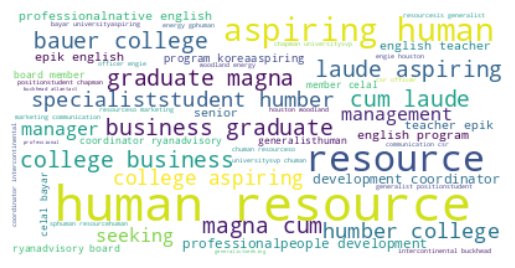

In [15]:
# Create and generate a word cloud image 
text = ''.join(data['job_title'])
my_cloud = WordCloud(background_color='white').generate(text)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")

# show the final image
plt.show()

In [16]:
keywords = ['aspiring human resources', 'seeking human resources']

## Bert Embeddings

In [17]:
class Bert_score:
    def __init__(self,df,col):
        self.df = df
        self.col = col
    
    def get_encoding(self, keyword):
        model_name = 'bert-base-nli-mean-tokens' 
        model = SentenceTransformer(model_name)
        text = list(self.df[self.col])
        sentence_vecs = model.encode(text)
        keywords_vecs = model.encode(keyword) 
        return sentence_vecs, keywords_vecs
    
    def rank_candidates(self):
    # calculate cosine similarity between each document and each search vector
        BertScore = []
        keywords = ['aspiring human resources', 'seeking human resources']
        sentence_vecs, keywords_vecs = self.get_encoding(keywords)
        for i in range(len(self.df[self.col])):
            score1 = cosine_similarity(sentence_vecs[i].reshape(1,-1), keywords_vecs[0].reshape(1,-1))
            score2 = cosine_similarity(sentence_vecs[i].reshape(1,-1), keywords_vecs[1].reshape(1,-1))
            BertScore.append(np.mean(np.concatenate((score1,score2)).flatten()))
        # Add the BERT scores as a new column to the dataset
        self.df['Bert Score'] = BertScore
        final_df = self.df.sort_values('Bert Score',ascending = False)
        return final_df

In [18]:
get_ranking = Bert_score(data, 'job_title')
get_ranking.rank_candidates()

,id,job_title,location,connection,Bert Score
98,99,seeking human resource position,"Las Vegas, Nevada Area",48,0.901509
27,28,seeking human resource opportunity,"Chicago, Illinois",390,0.892522
29,30,seeking human resource opportunity,"Chicago, Illinois",390,0.892522
35,36,aspiring human resource specialist,Greater New York City Area,1,0.843139
23,24,aspiring human resource specialist,Greater New York City Area,1,0.843139
...,...,...,...,...,...
90,91,lead official western illinois university,Greater Chicago Area,39,0.335223
84,85,rrp brand portfolio executive jti japan tobacc...,Greater Philadelphia Area,500,0.241109
92,93,admission representative community medical cen...,"Long Beach, California",9,0.205022
95,96,student indiana university kokomo business man...,"Lafayette, Indiana",19,0.179034


## TfIdf Score

In [19]:
vectorizer = TfidfVectorizer()
# generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform(list(data['job_title']))
tfidf_keywords = vectorizer.transform(keywords)

In [20]:
tfidf_score =[]
for i in range(len(data)):
  score1 = cosine_similarity(tfidf_keywords[0].reshape(1,-1), tfidf_matrix[i].reshape(1,-1))
  score2 = cosine_similarity(tfidf_keywords[1].reshape(1,-1), tfidf_matrix[i].reshape(1,-1))
  tfidf_score.append(np.mean(np.concatenate((score1,score2)).flatten()))
data['tfidf_score'] = tfidf_score

In [21]:
data.sort_values(by=['tfidf_score'],ascending=False)

,id,job_title,location,connection,Bert Score,tfidf_score
72,73,aspiring human resource manager seeking intern...,"Houston, Texas Area",7,0.648440,0.466700
32,33,aspiring human resource professional,"Raleigh-Durham, North Carolina Area",44,0.827415,0.410316
2,3,aspiring human resource professional,"Raleigh-Durham, North Carolina Area",44,0.827415,0.410316
57,58,aspiring human resource professional,"Raleigh-Durham, North Carolina Area",44,0.827415,0.410316
16,17,aspiring human resource professional,"Raleigh-Durham, North Carolina Area",44,0.827415,0.410316
...,...,...,...,...,...,...
62,63,student chapman university,"Lake Forest, California",2,0.418904,0.000000
63,64,svp chuman resourceso marketing communication ...,"Houston, Texas Area",500,0.390626,0.000000
17,18,people development coordinator ryan,"Denton, Texas",500,0.737968,0.000000
41,42,svp chuman resourceso marketing communication ...,"Houston, Texas Area",500,0.390626,0.000000


### Re-Ranking with Bert Score

In [22]:
starred_candidate = int(input('Enter the id of the candidate you want to star: '))
if starred_candidate in list(data['id']):
    print('ID is valid')
else:
    print('Invalid ID')

Enter the id of the candidate you want to star: 35
ID is valid


In [23]:
# get encodings for keywords and sentences

model_name = SentenceTransformer('bert-base-nli-mean-tokens')

re_rank_keywords = data.loc[starred_candidate][1]
re_rank_vecs = model_name.encode(re_rank_keywords)

re_rank_sentence_vecs = model_name.encode(list(data['job_title']))

In [24]:
# Calculate cosine similarity scores between each job title and the reranked job title
RerankScore = []
for vec in re_rank_sentence_vecs:
    score = cosine_similarity(vec.reshape(1, -1), re_rank_vecs.reshape(1, -1))
    RerankScore.append(score[0][0])

# Add Rerank Scores as a new column to the dataset
data['Rerank Score'] = RerankScore

In [25]:
data.sort_values(by=['Rerank Score'],ascending=False)

,id,job_title,location,connection,Bert Score,tfidf_score,Rerank Score
35,36,aspiring human resource specialist,Greater New York City Area,1,0.843139,0.374445,1.000000
48,49,aspiring human resource specialist,Greater New York City Area,1,0.843139,0.374445,1.000000
5,6,aspiring human resource specialist,Greater New York City Area,1,0.843139,0.374445,1.000000
59,60,aspiring human resource specialist,Greater New York City Area,1,0.843139,0.374445,1.000000
23,24,aspiring human resource specialist,Greater New York City Area,1,0.843139,0.374445,1.000000
...,...,...,...,...,...,...,...
90,91,lead official western illinois university,Greater Chicago Area,39,0.335223,0.000000,0.342473
95,96,student indiana university kokomo business man...,"Lafayette, Indiana",19,0.179034,0.000000,0.299315
84,85,rrp brand portfolio executive jti japan tobacc...,Greater Philadelphia Area,500,0.241109,0.000000,0.269461
92,93,admission representative community medical cen...,"Long Beach, California",9,0.205022,0.000000,0.193194


Inference:

* Done Text preprocessing such as removing stop words, punctuations and some unwanted characters, followed by text lemmatization.
* Created word cloud which shows "aspiring human resource" is more common than "seeking human resource".
* Applied Bert embeddings and tf-idf to find cosine similarity and found bert embeddings is more satisfactory, so re rank candidates when a candidate is starred by using bert transformation.